# SPRINT 1 FINANCER

### En quina mesura els clients amb saldos més baixos estan en més risc d'incompliment de crèdit, i com hem d'ajustar les nostres polítiques de crèdit permitigar aquest risc?


## 1. IMPORTACIÓ BD I CREACIÓ DE DF

In [3]:
from sqlalchemy import create_engine, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
%pip install pymysql
import pymysql
#Dades de connexió

usuario='EquipoB'
contraseña="E1q2u3i4p5oB"
host='212.227.90.6'
puerto=3306
nombre_base_datos='EquipB'

#URL de la connexió
url_conexion=f"mysql+pymysql://{usuario}:{contraseña}@{host}:{puerto}/{nombre_base_datos}"

#Crear l'engine de SQLAlchemy
try:
    engine=create_engine(url_conexion)
    cnx=engine.connect()
    print("conexió correcta")
except Exception as e:
    print(f"Error al conectar con SQLAlchemy: {e}")
    
#Obtenir nom de les taules
inspector=inspect(engine)
nombre_tablas=inspector.get_table_names()

#M'asseguro que la vista_finances també tingui el seu DF
if 'vista_finances' not in nombre_tablas:
    nombre_tablas.append('vista_finances')
#Emmagatzemar el DataFrames en una llista
df= {}

for taula in nombre_tablas:
    query=f"select * from {taula}"
    
    try:
        df[taula] = pd.read_sql(query, cnx)
        print(f"Taula '{taula}' carregada correctament.")
    except Exception as e:
        print(f"Error al carregar la taula '{taula}':{e}")

#cnx.close()

Note: you may need to restart the kernel to use updated packages.
conexió correcta
Taula 'BANK_marketing' carregada correctament.
Taula 'vista_finances' carregada correctament.


In [4]:
print(nombre_tablas)

['BANK_marketing', 'vista_finances']


## 2. EDA: ANÀLISI EXPLORATÒRI
Examinem les variables faltante i balance

In [5]:
df_bank = df['BANK_marketing']
df_vistaf = df['vista_finances']
df_vistaf.head()


,id,age,job,marital,education,faltante,balance,housing,loan
0,1,59,admin.,married,secondary,0,2343,1,0
1,3,56,admin.,married,secondary,0,45,0,0
2,4,41,technician,married,secondary,0,1270,1,0
3,5,55,services,married,secondary,0,2476,1,0
4,6,54,admin.,married,tertiary,0,184,0,0


In [6]:
len(df_vistaf)

11162

In [7]:
df_vistaf.describe()

,id,age,faltante,balance,housing,loan
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,5582.499910,41.232754,0.015051,1528.538524,0.473123,0.130801
std,3222.336342,11.910672,0.121761,3225.413326,0.499299,0.337198
min,1.000000,18.000000,0.000000,-6847.000000,0.000000,0.000000
25%,2792.250000,32.000000,0.000000,122.000000,0.000000,0.000000
50%,5582.500000,39.000000,0.000000,550.000000,0.000000,0.000000
75%,8372.750000,49.000000,0.000000,1708.000000,1.000000,0.000000
max,11163.000000,95.000000,1.000000,81204.000000,1.000000,1.000000


In [8]:
df_vistaf['faltante'].value_counts()

faltante
0    10994
1      168
Name: count, dtype: int64

In [9]:
df_vistaf['balance'].value_counts()

balance
 0       774
 1        39
 3        35
 2        34
 4        29
        ... 
 5517      1
 8332      1
 4859      1
-267       1
-134       1
Name: count, Length: 3805, dtype: int64

In [10]:
df_vistaf['balance'].isnull().sum()

0

Busquem posibles outliers a balance.

In [11]:
Q1 = df_vistaf['balance'].quantile(0.25)
Q3 = df_vistaf['balance'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df_vistaf['balance'] < (Q1-1.5*IQR)) | (df_vistaf['balance'] > (Q3 + 1.5*IQR))
outliers.sum()



1055

In [12]:
(1055/11162)*100

9.451711162874037

Representa un 9.45% de la mostra, son molts, vegem la distribució amb visualitzacions primer i després ens plantejarem com afrontar el problema.

### VISUALITZACIONS

#### FALTANTE

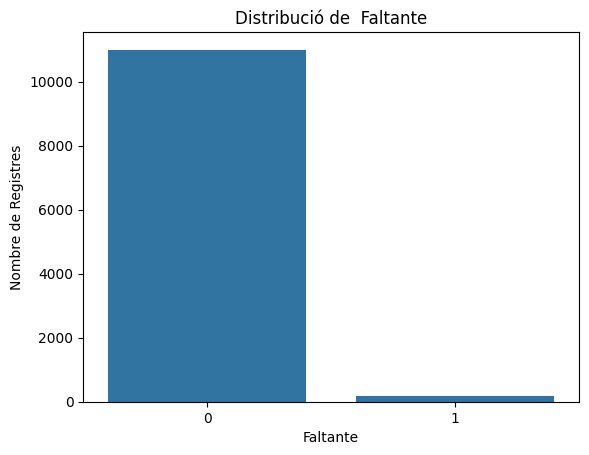

In [13]:
sns.countplot(x='faltante', data= df_vistaf)
plt.title('Distribució de  Faltante')
plt.xlabel('Faltante')
plt.ylabel('Nombre de Registres')
plt.show()

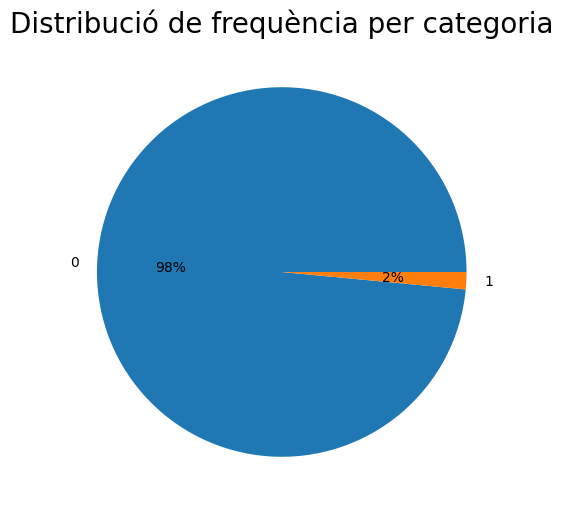

In [14]:
compteig_faltante= df_vistaf['faltante'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(compteig_faltante,labels=compteig_faltante.index, autopct='%1.0f%%')
plt.title("Distribució de frequència per categoria", fontsize=20 )
plt.show()

Podem veure que es una distribució molt asimètrica hi ha només un 2% de clients amb 'faltante' al banc. Es a dir el 98% dels clients no están en situació de morositat amb el banc.

#### BALANCE

<function matplotlib.pyplot.show(close=None, block=None)>

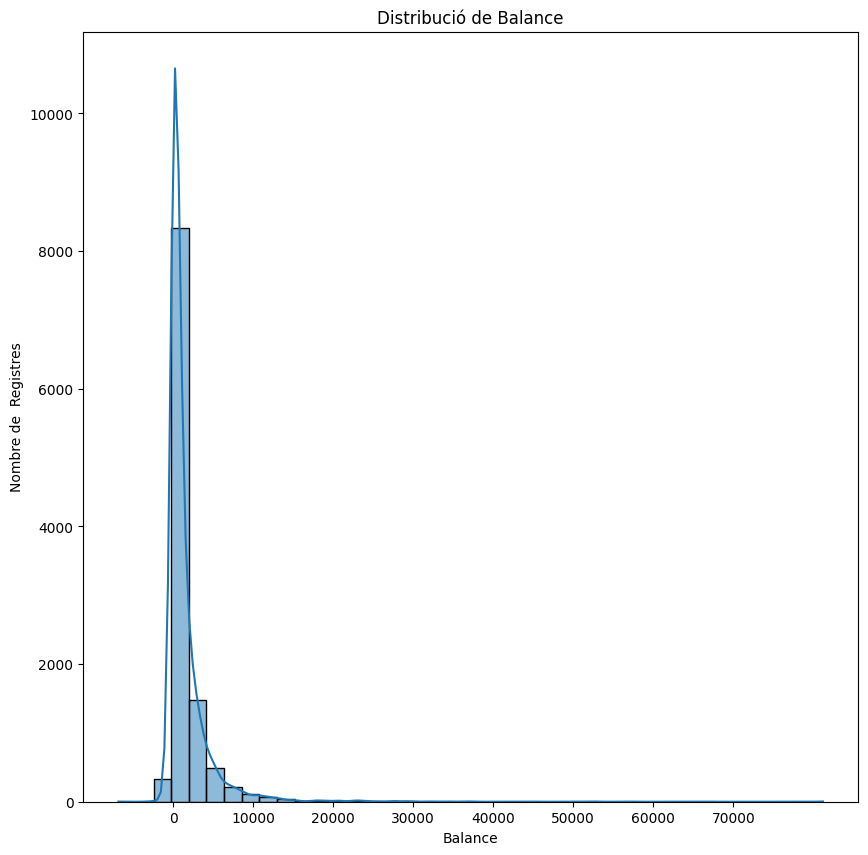

In [15]:
plt.figure(figsize=(10,10))
sns.histplot(df_vistaf['balance'], bins=40, kde=True)
plt.title('Distribució de Balance')
plt.xlabel('Balance')
plt.ylabel('Nombre de  Registres')
plt.xticks(range(0,80000,10000))
plt.show

Podem veure una distribució asimètrica amb cua a la dreta. Hi ha un pic molt destacat entre 0 i el proper bin on hi ha la inmensa majoria de registres. La majoria de clientes tenen balanços entre 0 i 2000,  mentre que molt pocs clients tenen blanços molt alts, de mes 50.000.

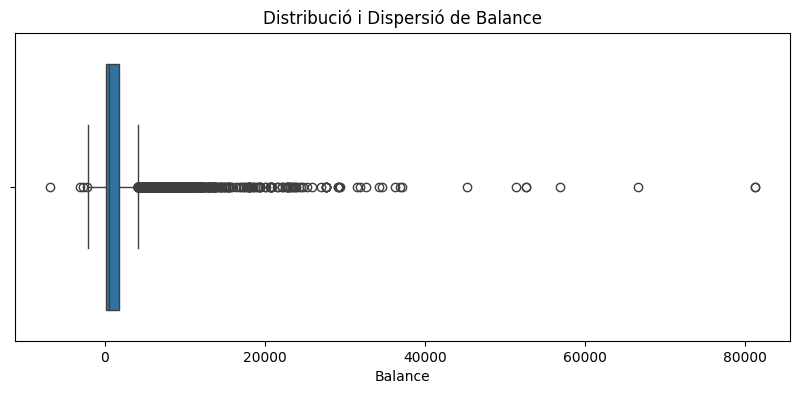

In [16]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df_vistaf['balance'])
plt.title('Distribució i Dispersió de Balance')
plt.xlabel('Balance')
plt.show()

Podem veure una caixa entre Q1 i Q3 molt estreta i, per tant una gran concentració de clients amb 'balance' entre 0 i 2000.
Veiem el gran nombre d'outliers que apareixen , sobretot per la dreta, confirmant el que mostrava el primer anàlisis numéric d'outliers.
Semblaria que la immensa majoria de clients utilitzen el banc com banc de gestió de nòmines i pagaments corrents i una petita part l'utlitza també coma  banc d'inversió i d'estalvi.
També es pot valorar la possibilitat que, aquesta distribució de 'balance', representi la distribució de la riquesa en la societat d'aquell país i que, per tant, poguem inferir que es tracta d'un país on la inmensa majoria de la gent no te estalvis, mentre que un minoria sí que en té.

## 3. ANÁLISIS COMPARATIVO BALANCE Vs DEFAULT

Ponemos en común nuestros análisis exploratorios y hablamos de los outliers. Finalmente decidimos
seguir la estrategia que propone Natalya para realizar el análisis comparativo de las dos variables:
categorizar la variable balance para ver como varia el porcentaje de incumplimiento de crédito en cada
categoría.

Ante el problema de los numerosos outliers de balance , en parte mitigado por la categorización de la
variable, decidimos seguir en paralelo el análisis comparativo de las dos variables, uno lo realiza sin
alterar la variable "balance" y otro tratando el problema de los outliers , así después podremos poner en común los resultados y sacar conclusiones.

Aplico el cambio de nombre de la variable "faltante" así como el de sus valores a si i no para hacer más claras las visualizaciones. De ser necesario, más adelante, se podrian transformar a booleanos.

In [17]:
df_vistaf['faltante']= df_vistaf['faltante'].replace({0:"no", 1:"si"})

df_vistaf = df_vistaf.rename(columns = {'faltante':'incumplimiento_crédito'})

### DISTRIBUCIÓN DE BALANCE CON INCUMPLIMIENTO Y SIN

Antes de profundizar en el análisis comparativo, realizo unas visualizaciones para comparar la distribución de balance de los clientes que estan en incumplimiento y los que no.

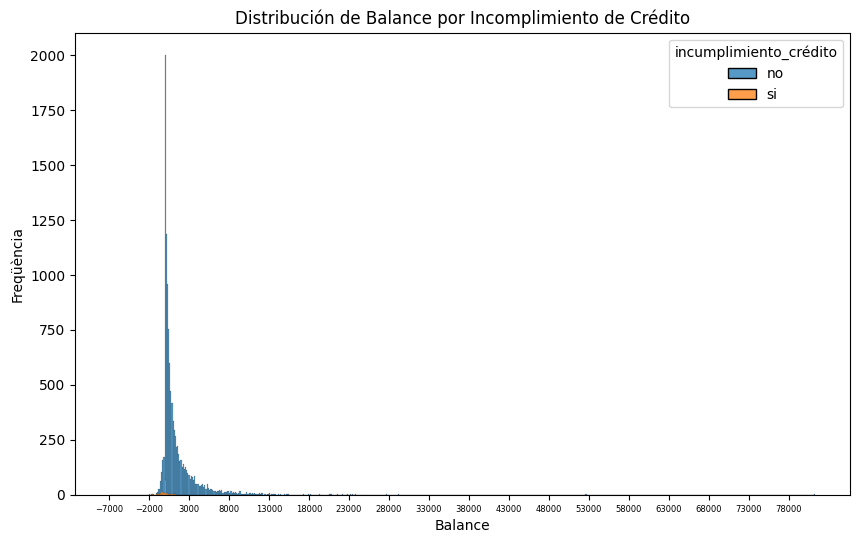

In [18]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df_vistaf, x='balance', hue='incumplimiento_crédito', multiple='stack')

plt.title('Distribución de Balance por Incomplimiento de Crédito')
plt.xlabel('Balance')
plt.ylabel('Freqüència')
plt.xticks(range(-7000,82000,5000), fontsize=6)
plt.show()

Para poder comparar mejor salvamos la gran diferencia de registros creando un gràfico de densidad.

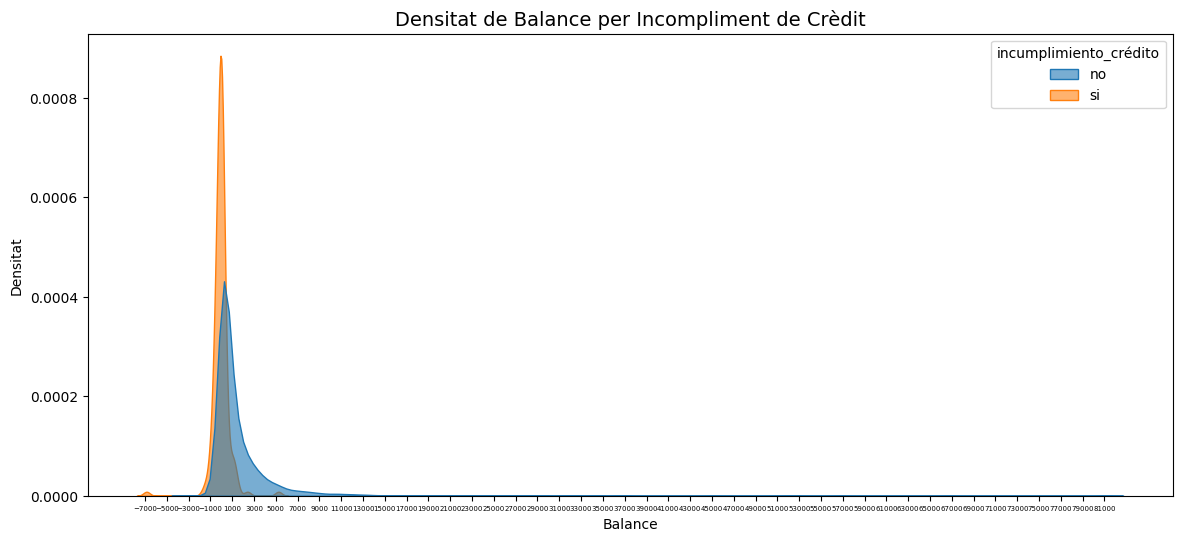

In [19]:
plt.figure(figsize=(14, 6))

sns.kdeplot(data=df_vistaf, x='balance', hue='incumplimiento_crédito', fill=True, common_norm=False, alpha=0.6)

plt.title('Densitat de Balance per Incompliment de Crèdit', fontsize=14)
plt.xlabel('Balance')
plt.ylabel('Densitat')

plt.xticks(range(-7000,82000,2000), fontsize=5)

plt.show()

### OUTLIERS
Viendo la distribución de "balance" y la gran cantidad de outliers (9,45%) se nos presentan varias opciones para su tratamiento: 
* Dejarlos: Eso es lo que hará Natalya para luego ponerlo en común.
* Eliminarlos: Aplicando la formula +- 1.5 * IQR.
* Truncar los valores en un tope determinado
* Estandarizar
* Aplicar una transformación logarítmica


Analizamos la composición de los outliers con más detenimiento.

                 id          age       balance      housing         loan
count   1055.000000  1055.000000   1055.000000  1055.000000  1055.000000
mean    5140.026540    44.426540   8413.330806     0.399052     0.063507
std     3183.738561    13.070966   6943.962727     0.489936     0.243988
min       11.000000    20.000000  -6847.000000     0.000000     0.000000
25%     2520.500000    34.000000   4929.500000     0.000000     0.000000
50%     4698.000000    42.000000   6281.000000     0.000000     0.000000
75%     7907.500000    53.000000   9203.000000     1.000000     0.000000
max    11103.000000    87.000000  81204.000000     1.000000     1.000000
<class 'pandas.core.frame.DataFrame'>
Index: 1055 entries, 9 to 11101
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      1055 non-null   int64 
 1   age                     1055 non-null   int64 
 2   job                     1055

([<matplotlib.axis.XTick at 0x277dd577a90>,
 [Text(-7000, 0, '−7000'),
  Text(-5000, 0, '−5000'),
  Text(-3000, 0, '−3000'),
  Text(-1000, 0, '−1000'),
  Text(1000, 0, '1000'),
  Text(3000, 0, '3000'),
  Text(5000, 0, '5000'),
  Text(7000, 0, '7000'),
  Text(9000, 0, '9000'),
  Text(11000, 0, '11000'),
  Text(13000, 0, '13000'),
  Text(15000, 0, '15000'),
  Text(17000, 0, '17000'),
  Text(19000, 0, '19000'),
  Text(21000, 0, '21000'),
  Text(23000, 0, '23000'),
  Text(25000, 0, '25000'),
  Text(27000, 0, '27000'),
  Text(29000, 0, '29000'),
  Text(31000, 0, '31000'),
  Text(33000, 0, '33000'),
  Text(35000, 0, '35000'),
  Text(37000, 0, '37000'),
  Text(39000, 0, '39000'),
  Text(41000, 0, '41000'),
  Text(43000, 0, '43000'),
  Text(45000, 0, '45000'),
  Text(47000, 0, '47000'),
  Text(49000, 0, '49000'),
  Text(51000, 0, '51000'),
  Text(53000, 0, '53000'),
  Text(55000, 0, '55000'),
  Text(57000, 0, '57000'),
  Text(59000, 0, '59000'),
  Text(61000, 0, '61000'),
  Text(63000, 0, '630

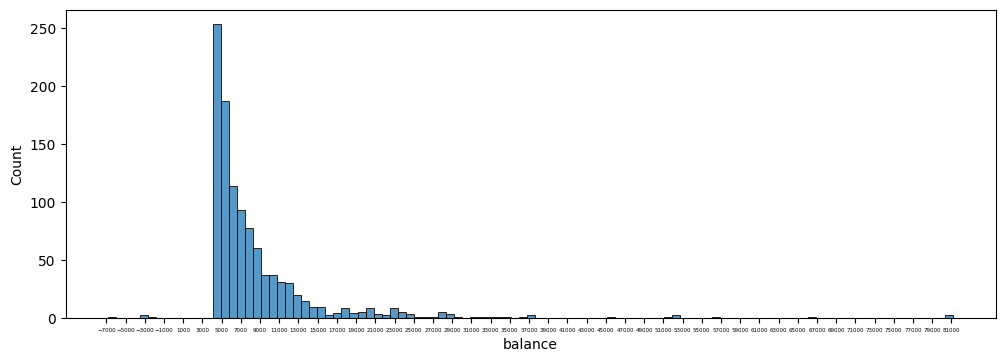

In [20]:
df_outliers = df_vistaf[outliers]

print(df_outliers.describe())
print(df_outliers.info())

plt.figure(figsize=(12,4))
sns.histplot(df_outliers['balance'])
plt.xticks(range(-7000,82000,2000),fontsize = 4)

Viendo la distribuición tan asimétrica de los outliers, totalmente decantada hacia los valores más altos, decido que el mejor método para tratar los outliers será aplicar una transformación logarítmica, ya que es el mejor método para valores muy altos en distribuciones con mucha dispersión.

Además considero que los otros métodos no serían del todo adequados:

Eliminarlos sería desvirtuar la muestra y alterar totalmente los datos reales. 
Para truncarlos necesitaria aplicar un valor de límite y necessitaria un mayor conocimiento de la muestra y del mundo financiero. Además también estaría alterando la muestra.
La estandarización sería una solución más neutra y no altera los datos però, en realidad, tampoco resuelve el problema de la "deformación" de la muestra por culpa de los numerosos y muy extremos outliers.

La transformación logaritmica sí corrige la "deformación" de la muestra por los outliers, pero tambien varia en cierta medida la relación entre los valores, cosa que considero un mal menor.
El único impedimento para realizarlo es que no se puede aplicar con valores negativos así que opto por la solucion más fácil i más inocua: Sumar una constante del valor mínimo + 1 a todos los valores y después aplicar la transformacion logarítmica con el logarimo natural de cada valor resultante:

log(x+(min+1))

In [21]:
min_balance = df_vistaf['balance'].min()
df_vistaf['balance_log'] = np.log(df_vistaf['balance'] + abs(min_balance) + 1)
df_vistaf[['balance', 'balance_log']].head()

,balance,balance_log
0,2343,9.125980
1,45,8.838262
2,1270,9.001839
3,2476,9.140347
4,184,8.858226


#### CATEGORIZACION
Primero definimos los cuartiles.

In [32]:
def cuartiles(df):
    #calcular cuartiles
    Q1 = df.quantile(0.25)
    Q2 = df.quantile(0.50)
    Q3 = df.quantile(0.75)

    #calcular IQR (rango intercuartílico)
    IQR = Q3 - Q1

    #calcular límite outliers
    min_Q = Q1 - 1.5*IQR
    max_Q = Q3 + 1.5*IQR
    
    return Q1, Q2, Q3, min_Q, max_Q

Q1, Q2, Q3, min_Q, max_Q = cuartiles(df_vistaf['balance_log'])

Asignamos las categorias según los cuartiles creados.

In [33]:
def clasificacion_clientes (balance):
    if balance < min_Q:
        return '1.muy bajo'
    elif balance < Q1:
        return '2.bajo'
    elif balance < Q2:
        return '2.medio-bajo'
    elif balance < Q3:
        return '4.medio-alto'
    elif balance < max_Q:
        return '5.alto'
    else:
        return '6.muy alto'
    
df_vistaf['descripcion_balance'] = df_vistaf['balance_log'].apply(clasificacion_clientes)

df_vistaf.head()

,id,age,job,marital,education,incumplimiento_crédito,balance,housing,loan,balance_log,descripcion_balance,incumplimiento_crédito_num,balance_bins
0,1,59,admin.,married,secondary,no,2343,1,0,9.125980,5.alto,0,"(1958.1, 10763.2]"
1,3,56,admin.,married,secondary,no,45,0,0,8.838262,2.bajo,0,"(-6935.051, 1958.1]"
2,4,41,technician,married,secondary,no,1270,1,0,9.001839,4.medio-alto,0,"(-6935.051, 1958.1]"
3,5,55,services,married,secondary,no,2476,1,0,9.140347,5.alto,0,"(1958.1, 10763.2]"
4,6,54,admin.,married,tertiary,no,184,0,0,8.858226,2.medio-bajo,0,"(-6935.051, 1958.1]"


In [38]:
df_vistaf['balance_log'].min()
df_vistaf['balance_log'].max()

11.385682828033222

Ahora comparamos las dos variables categoricas, creando la media de incumpliento por cada categoria de balance para visualizarlo.

<function matplotlib.pyplot.show(close=None, block=None)>

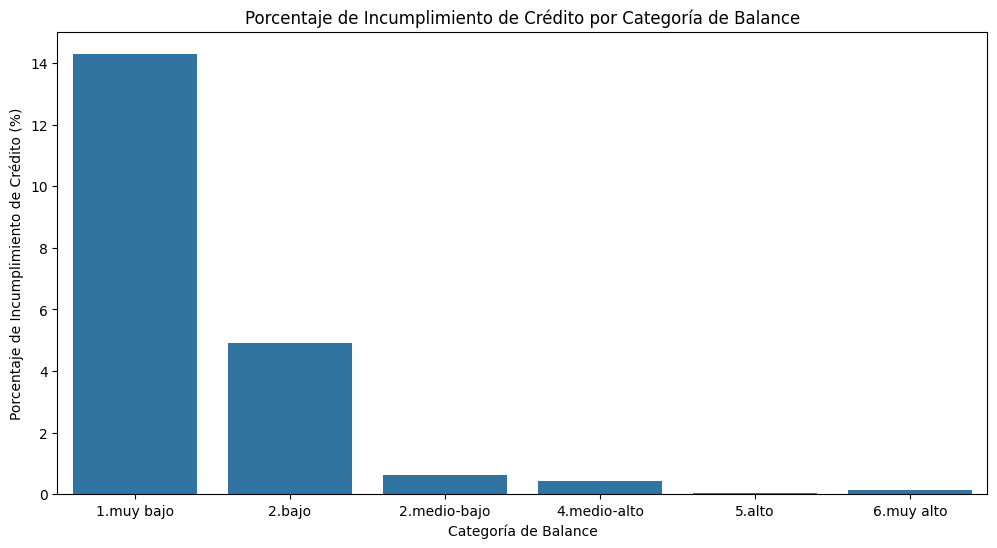

In [34]:
# volvemos a convertir los valores de incumplimiento a numéricos para calcular el % 
df_vistaf['incumplimiento_crédito_num'] = df_vistaf['incumplimiento_crédito'].map({'si': 1, 'no': 0})
incumplimiento_categoria = df_vistaf.groupby('descripcion_balance')['incumplimiento_crédito_num'].mean() * 100
# Convertimos a un DataFrame para facilitar la visualización
incumplimiento_categoria = incumplimiento_categoria.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=incumplimiento_categoria, x='descripcion_balance', y='incumplimiento_crédito_num')
plt.title('Porcentaje de Incumplimiento de Crédito por Categoría de Balance')
plt.xlabel('Categoría de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.show


REALIZO LA MISMA VISUALIZACIÓN PERO CON UNA CATEGORIZACION SIN PONDERAR (CREADA AUTOMATICAMENTE POR RANGOS DE BALANCE) CON MAYOR NÚMERO DE BINS Y EN FORMA DE GRAFICO DE LINEAS.

1. CON BALANCE_LOG

C:\Users\ueret\AppData\Local\Temp\ipykernel_13604\2575516953.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incumplimiento_por_bin = df_vistaf.groupby('balance_bins')['incumplimiento_crédito_num'].mean() * 100
C:\Users\ueret\AppData\Local\Temp\ipykernel_13604\2575516953.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='incumplimiento_crédito_num', ci=None)
C:\Users\ueret\AppData\Local\Temp\ipykernel_13604\2575516953.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


[Text(0, 0, '-0.0 - 0.6'),
 Text(1, 0, '0.6 - 1.1'),
 Text(2, 0, '1.1 - 1.7'),
 Text(3, 0, '1.7 - 2.3'),
 Text(4, 0, '2.3 - 2.8'),
 Text(5, 0, '2.8 - 3.4'),
 Text(6, 0, '3.4 - 4.0'),
 Text(7, 0, '4.0 - 4.6'),
 Text(8, 0, '4.6 - 5.1'),
 Text(9, 0, '5.1 - 5.7'),
 Text(10, 0, '5.7 - 6.3'),
 Text(11, 0, '6.3 - 6.8'),
 Text(12, 0, '6.8 - 7.4'),
 Text(13, 0, '7.4 - 8.0'),
 Text(14, 0, '8.0 - 8.5'),
 Text(15, 0, '8.5 - 9.1'),
 Text(16, 0, '9.1 - 9.7'),
 Text(17, 0, '9.7 - 10.2'),
 Text(18, 0, '10.2 - 10.8'),
 Text(19, 0, '10.8 - 11.4')]

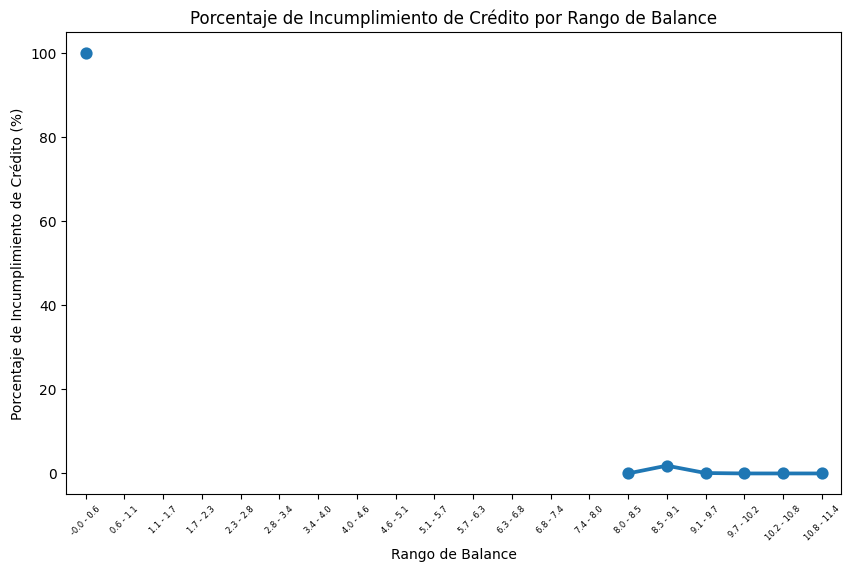

In [42]:
# Crear bins para el balance (agrupando los valores en categorías)
df_vistaf['balance_bins'] = pd.cut(df_vistaf['balance_log'], bins=20)  
# Calcular el porcentaje de incumplimiento por cada bin de balance
incumplimiento_por_bin = df_vistaf.groupby('balance_bins')['incumplimiento_crédito_num'].mean() * 100
# Convertir el resultado a DataFrame para facilitar la visualización
incumplimiento_por_bin = incumplimiento_por_bin.reset_index()


plt.figure(figsize=(10, 6))
sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='incumplimiento_crédito_num', ci=None)

plt.title('Porcentaje de Incumplimiento de Crédito por Rango de Balance')
plt.xlabel('Rango de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.xticks(rotation=45, fontsize=6)
plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


In [ ]:
2. CON BALANCE

C:\Users\ueret\AppData\Local\Temp\ipykernel_13604\3029528287.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incumplimiento_por_bin = df_vistaf.groupby('balance_bins')['incumplimiento_crédito_num'].mean() * 100
C:\Users\ueret\AppData\Local\Temp\ipykernel_13604\3029528287.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='incumplimiento_crédito_num', ci=None)
C:\Users\ueret\AppData\Local\Temp\ipykernel_13604\3029528287.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


[Text(0, 0, '-6935.1 - -2444.4'),
 Text(1, 0, '-2444.4 - 1958.1'),
 Text(2, 0, '1958.1 - 6360.6'),
 Text(3, 0, '6360.6 - 10763.2'),
 Text(4, 0, '10763.2 - 15165.8'),
 Text(5, 0, '15165.8 - 19568.3'),
 Text(6, 0, '19568.3 - 23970.8'),
 Text(7, 0, '23970.8 - 28373.4'),
 Text(8, 0, '28373.4 - 32775.9'),
 Text(9, 0, '32775.9 - 37178.5'),
 Text(10, 0, '37178.5 - 41581.1'),
 Text(11, 0, '41581.1 - 45983.6'),
 Text(12, 0, '45983.6 - 50386.2'),
 Text(13, 0, '50386.2 - 54788.7'),
 Text(14, 0, '54788.7 - 59191.2'),
 Text(15, 0, '59191.2 - 63593.8'),
 Text(16, 0, '63593.8 - 67996.4'),
 Text(17, 0, '67996.4 - 72398.9'),
 Text(18, 0, '72398.9 - 76801.4'),
 Text(19, 0, '76801.4 - 81204.0')]

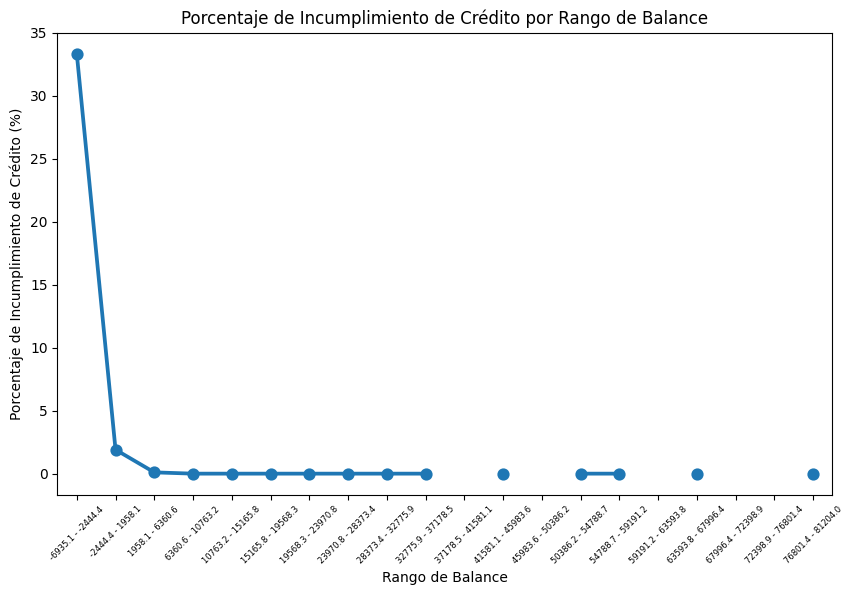

In [43]:
# Crear bins para el balance (agrupando los valores en categorías)
df_vistaf['balance_bins'] = pd.cut(df_vistaf['balance'], bins=20)  
# Calcular el porcentaje de incumplimiento por cada bin de balance
incumplimiento_por_bin = df_vistaf.groupby('balance_bins')['incumplimiento_crédito_num'].mean() * 100
# Convertir el resultado a DataFrame para facilitar la visualización
incumplimiento_por_bin = incumplimiento_por_bin.reset_index()


plt.figure(figsize=(10, 6))
sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='incumplimiento_crédito_num', ci=None)

plt.title('Porcentaje de Incumplimiento de Crédito por Rango de Balance')
plt.xlabel('Rango de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.xticks(rotation=45, fontsize=6)
plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


### LA RELACIÓN ENTRE LAS DOS VARIABLES ES MUY CLARA. HAY UNA RELACIÓN INVERSA ENTRE EL BALANCE Y LA TASA DE INCUMPLIMIENTO DE CRÉDITO.
Cuanto menor es el balance mucho mayor es la tasa de incumplimiento de crédito.

PD Se pueden hacer mejores visualizacione pero si terminaremos en PowerBi se pueden hacer allí